In [1]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2lab
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
import cv2
import numpy as np
import sys

In [2]:
# sys.argv=['Saliency_filter-Dirty.py','./images/eagle.jpg']

In [3]:
if (len(sys.argv) < 2):
    print("Error: File Name is missing.")
    print("Usage: python3 SaliencyFilter.py <location_of_file_along_with_filename>")
    quit()
    
ipFileName = sys.argv[1]

#print("Input File Name: ",ipFileName)
#ipImage  = io.imread(ipFileName)
namesplits = ipFileName.split('.')
fileExt = namesplits[-1]
fileExtLen = len(fileExt)
salFileName = ipFileName[0:-(fileExtLen+1)]+"_sal"+ipFileName[-(fileExtLen+1):]
absFileName = ipFileName[0:-(fileExtLen+1)]+"_abs"+ipFileName[-(fileExtLen+1):]
uniqFileName = ipFileName[0:-(fileExtLen+1)]+"_uniq"+ipFileName[-(fileExtLen+1):]
distFileName = ipFileName[0:-(fileExtLen+1)]+"_dist"+ipFileName[-(fileExtLen+1):]
segFileName = ipFileName[0:-(fileExtLen+1)]+"_seg"+ipFileName[-(fileExtLen+1):]

    

In [4]:
sigmap = 0.25
sigmac = 20
nSegments=500

def giveSSD(x1,x2):
    return np.sqrt(np.sum(np.square(x1-x2)))

def wp(pi,pj):
    
    return np.exp((-1/2*(sigmap**2))*np.square(giveSSD(pi,pj)))

def wc(ci,cj):
    
    return np.exp((-1/2*(sigmac**2))*np.square(giveSSD(ci,cj)))



def abstract(i):  
    
    image=i
    image_norm=img_as_float(image)
    lab = rgb2lab(image_norm)
    lab_norm=(lab + np.array([0, 128, 128])) / np.array([100, 255, 255])
    segments = slic(image_norm, n_segments = nSegments, compactness=20, sigma = 1,multichannel=True, convert2lab=True)
    #segments = slic(image, n_segments=self.__n_segments,enforce_connectivity=True, compactness=30.0,convert2lab=False)

    # show the output of SLIC

    plt.imshow(mark_boundaries(image, segments))
    plt.savefig(segFileName)
    #plt.show()
    n_segments = segments.max() + 1

    # construct position matrix
    max_y, max_x = np.array(segments.shape) - 1
    x = np.linspace(0, max_x, image.shape[1]) / max_x
    y = np.linspace(0, max_y, image.shape[0]) / max_y
    position = np.dstack((np.meshgrid(x, y)))

    mean_colors = np.zeros((n_segments, 3))
    mean_position = np.zeros((n_segments, 2))
    clrs=np.zeros((n_segments, 3))
    for i in np.unique(segments):
        mask = segments == i
        mean_colors[i,:]=lab[mask,:].mean(axis=0)
        mean_position[i, :] = position[mask, :].mean(axis=0)

#     mean_position
#     mean_colors
    d_abstract={}

    d={}
    d1={}
    d_abst={}
    d_uniqueness={}
    r,c=segments.shape
    for i in range (r):
        for j in range (c):
            d[segments[i,j]]=[]
            d_uniqueness[segments[i,j]]=[]
            d1[segments[i,j]]=[]


    for i in range (r):
        for j in range (c):
            d[segments[i,j]].append([i,j])
            d1[segments[i,j]].append(image_norm[i,j])

    image_copy=np.copy(image_norm)
    
    for i in range (r):
        for j in range (c):
            image_copy[i,j]= np.median(d1[segments[i,j]],axis=0)
            d_uniqueness[segments[i,j]].append([image_copy[i,j]])
            
            
    output=(image_copy*255).astype('uint8')
    for i in d_uniqueness.keys():
        
        clrs[i]=d_uniqueness[i][0][0]

    
    return clrs,mean_position,segments,d,output,d_uniqueness

    

def uniquenessAssignment(c,p):
    U = np.empty(len(c))
    for i in range(len(c)):
        Zi=0
        pi = p[i]
        ci = c[i]
        tUniq = 0;
        
        for j in range(len(c)):
            #if i != j:
            pj = p[j] 
            cj=c[j]
            Zi+= wp(pi,pj)

        
        for j in range(len(c)):
            #if i != j:
            pj = p[j] 
            cj=c[j]
            tUniq += np.square(giveSSD(ci,cj))*(1/Zi)*wp(pi,pj)    

        U[i] = tUniq
    
    return U

def distributionAssignment(c,p):
    D = np.zeros(len(c))
    
    
    for i in range(len(c)):
        Zi=0    
        meani = 0
        tDist = 0
    
        ci = c[i]
        pi = p[i]
        
        for j in range(len(c)):
            cj = c[j] 
            Zi+= wc(ci,cj)
        
        for j in range(len(c)):
            cj = c[j] 
            pj = p[j]
            #if (i != j):
            meani += (1/Zi) * wc(ci,cj)*pj
        
        
        for j in range(len(c)):
            cj = c[j] 
            pj = p[j]
            tDist += np.square(giveSSD(pj,meani))*(1/Zi)*wc(ci,cj)
            
        D[i] = tDist
        
        
    return D
def saliency_Assignment(U_norm,dist_norm,colors,positions):
    k=3
    Si = np.ones(len(colors))
    S=np.ones(len(colors))
    Si = U_norm* np.exp(-k*dist_norm);
    for i in range(len(colors)):
        Zi=0
        pi = positions[i]
        ci = colors[i]
        tUniq = 0;

        for j in range(len(colors)):
            #if i != j:
            pj = positions[j] 
            cj = colors[j]
            Zi+=np.exp((-1/2*(1/10))*np.square(giveSSD(ci,cj)))*np.exp((-1/2*(1/30))*np.square(giveSSD(pi,pj)))


        for j in range(len(colors)):
            #if i != j:
            pj = positions[j] 
            cj = colors[j]
            tUniq +=(1/Zi)*np.exp((-1/2*(1/10))*np.square(giveSSD(ci,cj)))*np.exp((-1/2*(1/30))*np.square(giveSSD(pi,pj)))*Si[i] 

        S[i] = tUniq

    return S


    


True

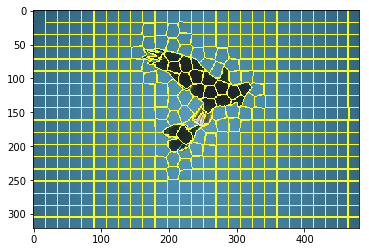

In [5]:
from skimage import io
image=io.imread(ipFileName)
image_uniqueness=np.zeros((image.shape[0],image.shape[1],3))
image_distribution=np.zeros((image.shape[0],image.shape[1],3))
image_saliency=np.zeros((image.shape[0],image.shape[1],3))

colors=[]
positions=[]
colors,positions,seg,d_p,o,d_u = abstract(image)

Uniqueness=uniquenessAssignment(colors,positions)
U_norm=Uniqueness/max(Uniqueness)

dist=distributionAssignment(colors,positions)
dist.shape
dist_norm=dist/max(dist)


sal=saliency_Assignment(U_norm,dist_norm,colors,positions)    


for i in range(len(d_p)):
    for k in range(len(d_p[i])):
        
        row=d_p[i][k][0]
        col=d_p[i][k][1]
        image_uniqueness[row,col]=Uniqueness[i]
        image_distribution[row,col]=dist_norm[i]
        image_saliency[row,col]=sal[i]

# io.imshow(o)
# io.show()
# io.imshow(image_uniqueness,cmap='gray')
# io.show()
# io.imshow(image_distribution,cmap='gray')
# io.show()
# io.imshow(image_saliency,cmap='gray')
# io.show()

io.imsave(absFileName,o)
cv2.imwrite(distFileName,image_distribution*255)
cv2.imwrite(uniqFileName,image_uniqueness*255)
cv2.imwrite(salFileName,image_saliency*255)


